 # Data Cleaning and Transformation
 
For this notebook, I will be using the following libraries:

- pandas for data manipulation.
- numpy for mathematical operations.
- seaborn and matplotlib for data visualizing.
- sklearn for machine learning.
- scipy for statistical operations.

## 1- Import the required libraries

In [1]:
# Data manipulation and mathematical operations
import pandas as pd
import numpy as np 

# Statistical computations
from scipy.stats import norm
from scipy import stats

# imputation
from sklearn.impute import KNNImputer

# encoding 
import category_encoders as ce
# Label Encoding
from sklearn.preprocessing import LabelEncoder
#One hot encoding 
from sklearn.preprocessing import OneHotEncoder



In [2]:
# Data visualization 

%matplotlib inline
import seaborn as sns 
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [66]:
### Define some useful functions 
#The function is used to determine the type of the column:Categorical or Numerical  
def utils_recognize_type(dtf, col, max_cat):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"
    
#####################################
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

########################################
def z_score(dataframe, threshold=1):
    mean, std = np.mean(dataframe), np.std(dataframe)
    z_score = np.abs((dataframe - mean) / std)
    good = z_score < threshold
    print(f"z-score of {threshold} corresponds to a prob of {100 * 2 * norm.sf(3):0.2f}%")
    print(f"Rejection {(~good).sum()} points")
    return good

This notebook includes some instructions that should be pursued by any data scientist before applying any machine learning algorithm. It is divided into two main parts as follow:

    - First part was used to present all required data cleaning instructions. 
    - Second part was used to illustrate all data transformation steps.

## 2- Data reading 

In [5]:
df=pd.read_csv('./data/weatherHistory.csv')
df.head(2)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.


In [6]:
# Giving look to the tail
df.tail(2)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.
96452,2016-09-09 23:00:00.000 +0200,Partly Cloudy,rain,20.438889,20.438889,0.61,5.8765,39.0,15.5204,0.0,1016.16,Partly cloudy starting in the morning.


## 3- Data cleaning
### 3.1- Primarily exploration

####  a. More information 

Here is more information about the features and types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


#### b. General Overview

Here is a statistical description of numerical features

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


Including all features either numerical or categorical

In [9]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Formatted Date,96453,96429,2010-08-02 00:00:00.000 +0200,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Summary,96453,27,Partly Cloudy,31733,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precip Type,95936,2,rain,85224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature (C),96453.0,NaN,NaN,NaN,11.932678,9.551546,-21.822222,4.688889,12.0,18.838889,39.905556
Apparent Temperature (C),96453.0,NaN,NaN,NaN,10.855029,10.696847,-27.716667,2.311111,12.0,18.838889,39.344444
Humidity,96453.0,NaN,NaN,NaN,0.734899,0.195473,0.0,0.6,0.78,0.89,1.0
Wind Speed (km/h),96453.0,NaN,NaN,NaN,10.81064,6.913571,0.0,5.8282,9.9659,14.1358,63.8526
Wind Bearing (degrees),96453.0,NaN,NaN,NaN,187.509232,107.383428,0.0,116.0,180.0,290.0,359.0
Visibility (km),96453.0,NaN,NaN,NaN,10.347325,4.192123,0.0,8.3398,10.0464,14.812,16.1
Loud Cover,96453.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### c. Values Count

If you want to know values count per feature. In the next example, I have selected 'avg_salary'

In [10]:
avg_salary_count=df['Temperature (C)'].value_counts().to_frame()
avg_salary_count

,Temperature (C)
7.222222,455
7.777778,408
12.777778,378
17.777778,373
6.111111,370
...,...
-4.816667,1
-4.716667,1
38.472222,1
-6.327778,1


#### d. Data frame shape 
My data frame contains 660 rows and 27 columns

In [11]:
df.shape

(96453, 12)

#### e.  Columns names 
Determining columns name in my data frame. Here I have 27 columns as I mentioned before. 

In [12]:
df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

#### f. Correlation and Correlation Matrix

Before starting any data cleaning process, it is important to establish a correlation between the target variable and any other feature. Correlation analysis is very useful, especially, in regression problems as it helps identifies the most important features or any other variable that has direct impact on the target variable. 

Thus, it distinguishes variables that should be discarded from our analysis as they have no relation with our target feature.

Many methods are useful to discover correlation between the target variable and the rest of the features such as pair plots, scatter plots, heatmaps and correlation matrix. Correlation coefficient can only be calculated on the numerical attributes (floats and integers), therefore, only the numeric attributes will be selected.

The correlation is calculated using the pearson correlation coefficient, which measures how closely two sequences of numbers are correlated. Therefore, only numerical attributes (floats and integers) are selected while calculating correlation coefficient.  



In [13]:
numerical_columns=['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 
'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']
df_select=df[numerical_columns]
df_select.head(2)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63


##### Paiplots

/Users/badiaamakhlouf/opt/anaconda3/envs/data_test/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


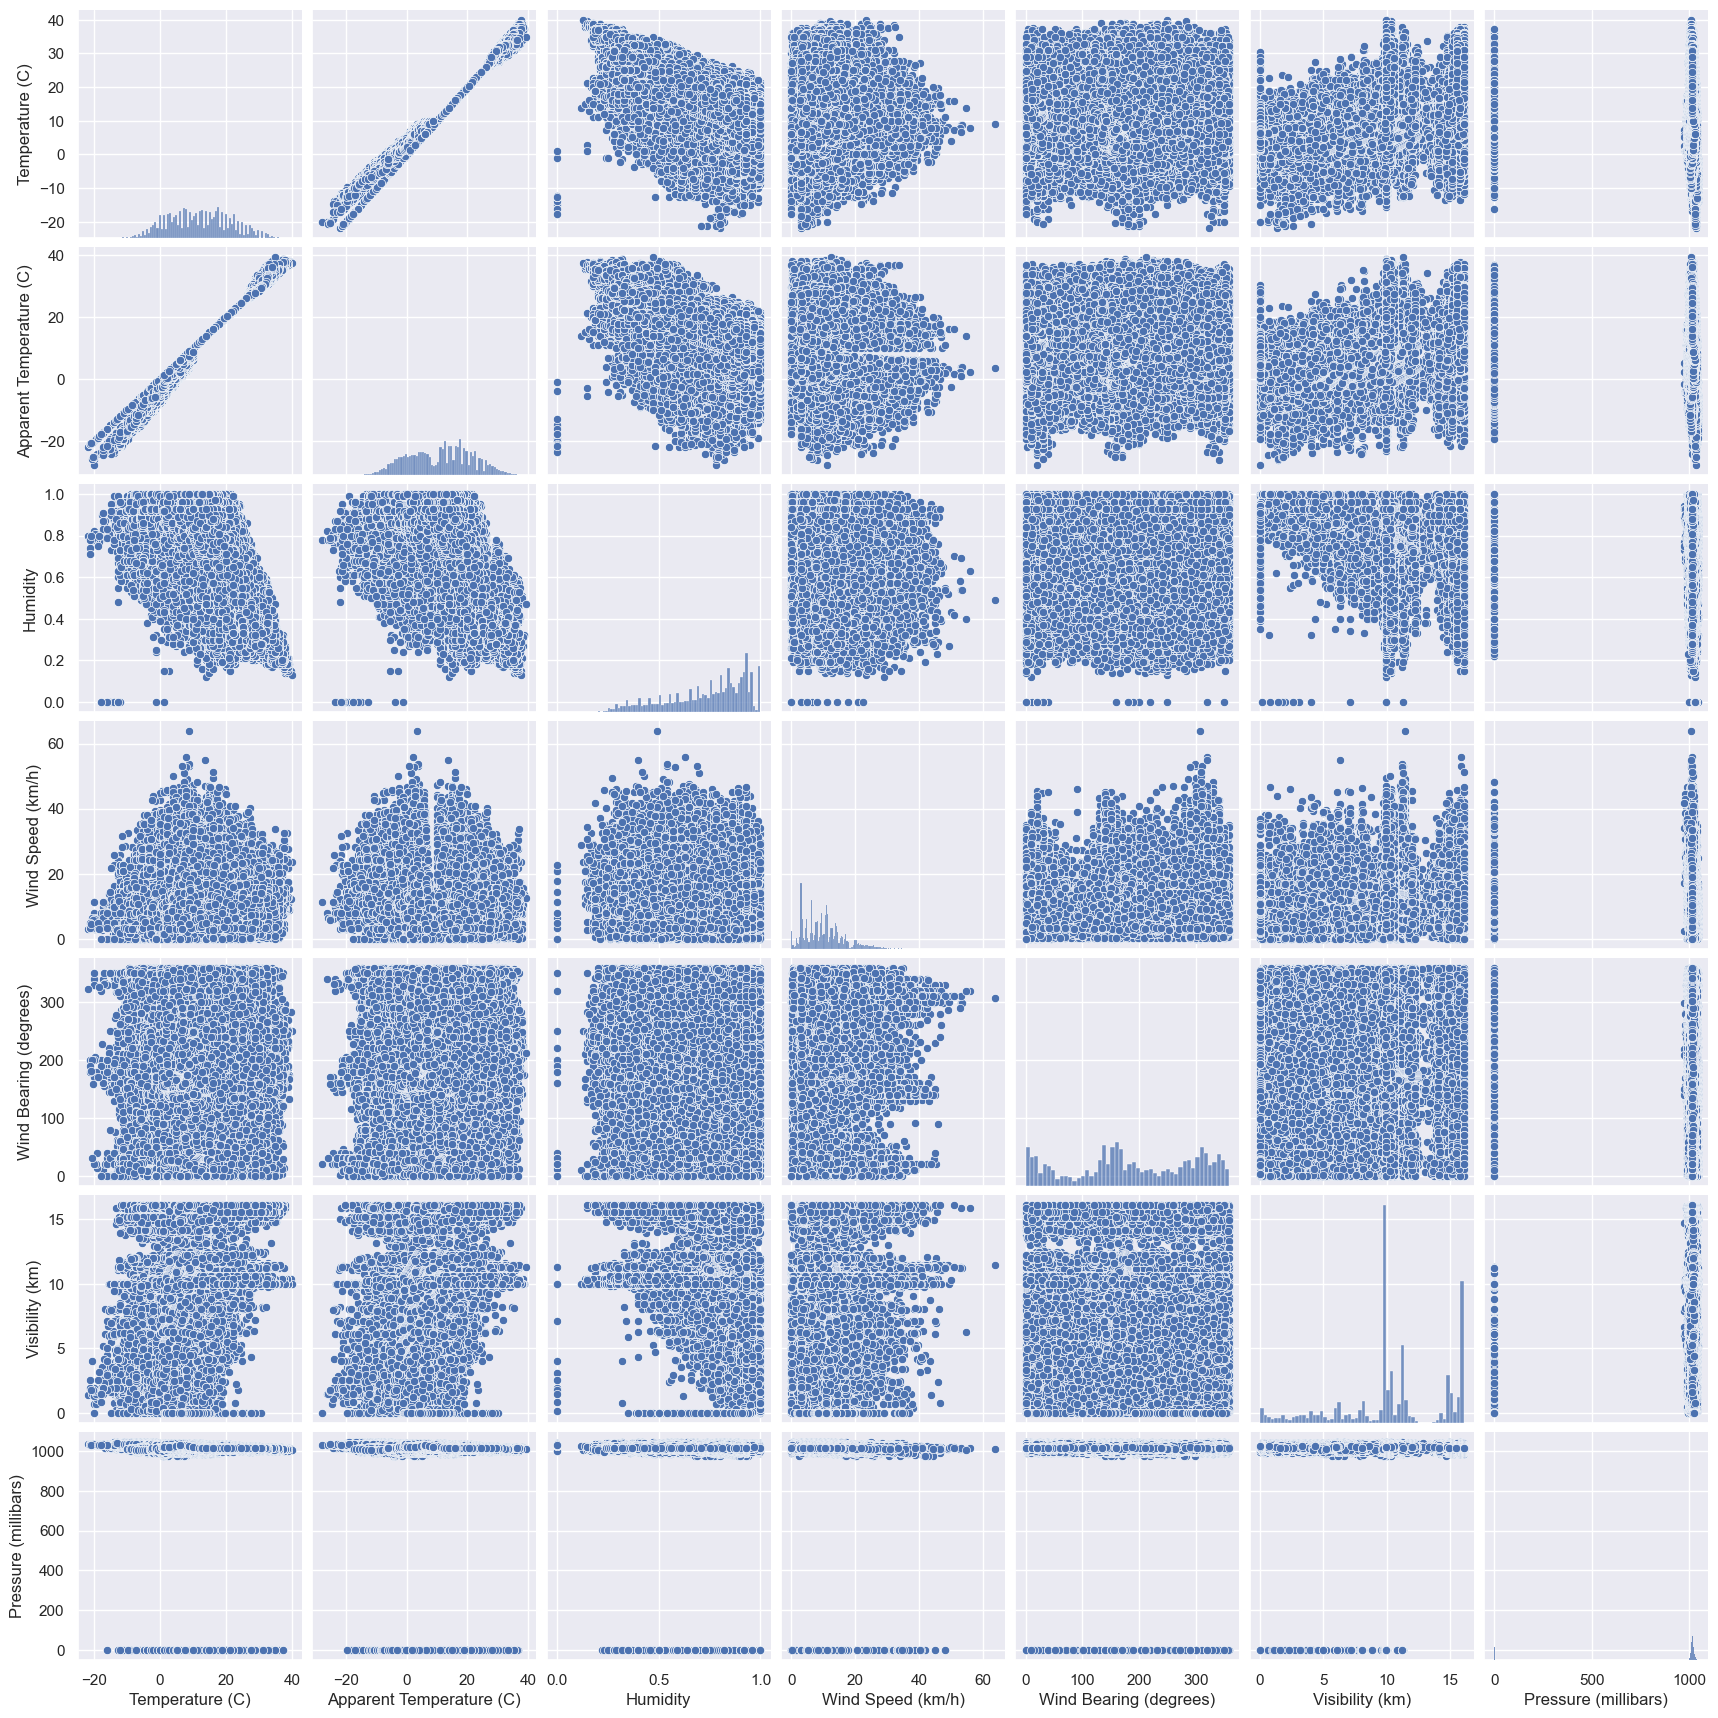

In [14]:
sns.set()
sns.pairplot(df_select, size = 2.5)
plt.show();

##### Correlation matrix and heatmap

Text(0.5, 1.0, 'Heat Map')

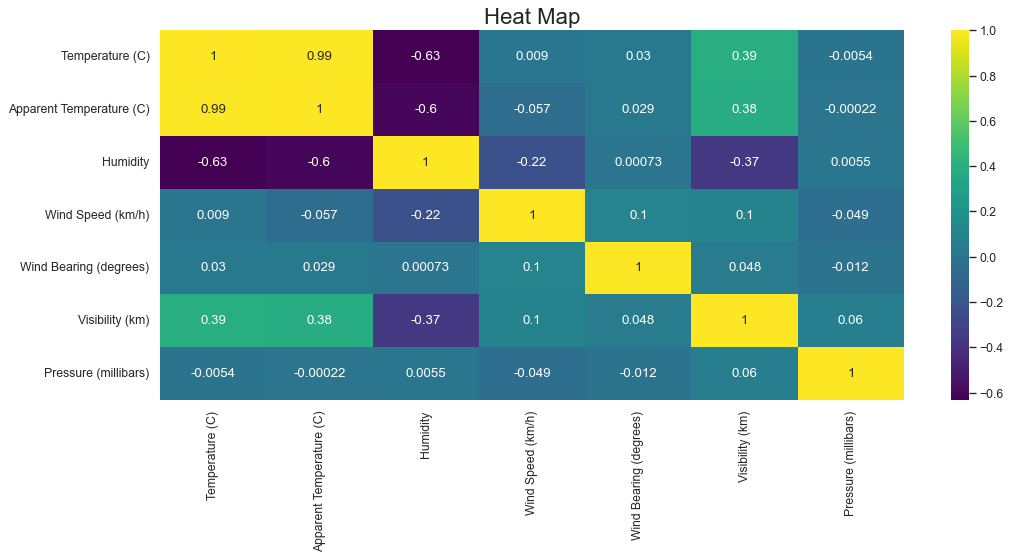

In [15]:
figure(figsize=(15, 6), dpi=80)
sns.heatmap(df_select.corr(), cmap='viridis', annot=True)
plt.title('Heat Map', fontsize =20)

In [16]:
corr_matrix=df_select.corr()
corr_matrix

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000


#### g. Data Distribution

Actually, distribution plots are more used during Exploratory Data Analysis because they illustrate the values range taken by each of our variables as well as which values occur most often.

I am going to select only two variables, which are 'Temperature (C)' and 'Humidity' to show.

/var/folders/x_/_mmvg5sn65b5cx8542pkt62w0000gp/T/ipykernel_7680/140145788.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_select['Temperature (C)'])
/var/folders/x_/_mmvg5sn65b5cx8542pkt62w0000gp/T/ipykernel_7680/140145788.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_select['H

<Axes: xlabel='Humidity', ylabel='Density'>

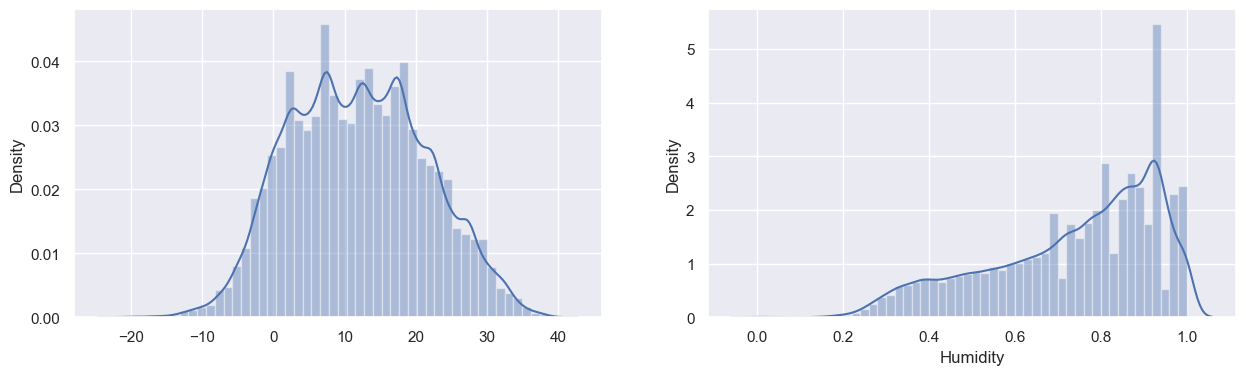

In [17]:
plt.figure(figsize=(15, 4))
#figure(figsize=(15, 4))
plt.subplot(1,2,1)
sns.distplot(x=df_select['Temperature (C)'])
plt.subplot(1,2,2)
sns.distplot(df_select['Humidity'])

<Axes: xlabel='Humidity', ylabel='Count'>

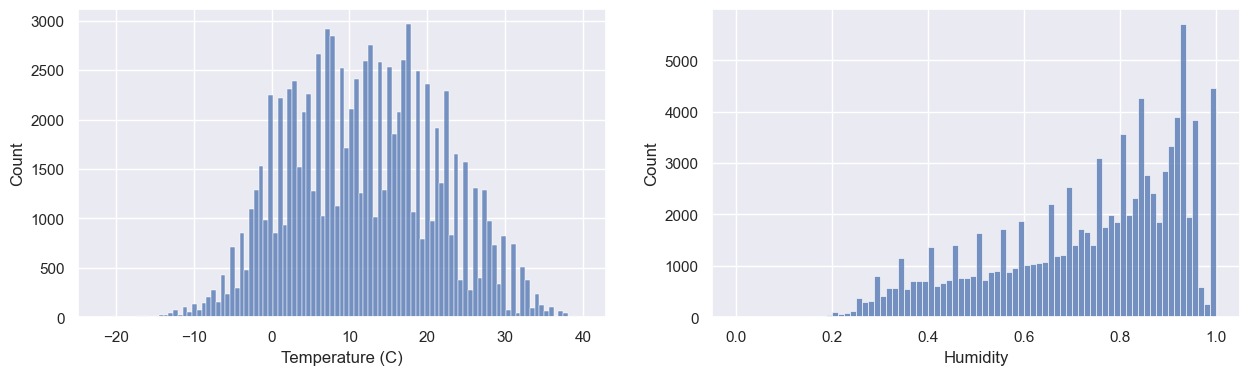

In [18]:
plt.figure(figsize=(15, 4))
#figure(figsize=(15, 4))
plt.subplot(1,2,1)
sns.histplot(x=df_select['Temperature (C)'])
plt.subplot(1,2,2)
sns.histplot(df_select['Humidity'])

### 3.3- Cleaning and preprocessing
Basically, we need to address anything that could undermine the functionality and effectiveness of the model used to extract insight.

- Check data inconsistencies, fix corrupt data, find missing data
- Finding and removing the outliers
- Impute missing data
- Scaling the data : numerical data



#### a. Handling the Duplicates

In [19]:
duplicate = df[df.duplicated(['Temperature (C)'])]
duplicate

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
26,2006-04-10 02:00:00.000 +0200,Mostly Cloudy,rain,11.183333,11.183333,0.80,10.8192,163.0,14.9569,0.0,1008.71,Mostly cloudy throughout the day.
43,2006-04-10 19:00:00.000 +0200,Mostly Cloudy,rain,17.800000,17.800000,0.50,20.0445,150.0,11.2056,0.0,1008.36,Mostly cloudy throughout the day.
47,2006-04-10 23:00:00.000 +0200,Overcast,rain,14.255556,14.255556,0.59,16.5025,168.0,14.9569,0.0,1007.89,Mostly cloudy throughout the day.
48,2006-04-11 00:00:00.000 +0200,Overcast,rain,13.772222,13.772222,0.60,17.0982,160.0,15.8263,0.0,1007.36,Foggy in the evening.
52,2006-04-11 04:00:00.000 +0200,Overcast,rain,11.183333,11.183333,0.89,11.2056,180.0,9.9015,0.0,1006.73,Foggy in the evening.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


To delete duplicates, I have used `drop_duplicates()`, which removes all duplicate rows based on all the columns.

In [20]:
# To delete duplicates 
dup_removed = df.drop_duplicates()
dup_removed 

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


To check if there are any duplicated Indexes in our dataset, we can use index.is_unique function.

In [21]:
df.index.is_unique

True

#### b. Handling missing values
##### Finding the Missing Values
Pandas has already provides some predefined function for detecting missing values, easily. Those functions are isna(), isnull(), and notna() functions.

In [22]:
df.isnull().sum().sort_values(ascending=False)


Precip Type                 517
Formatted Date                0
Summary                       0
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

Three main methods to deal with NaN, missing values: 

- Simple solution: drop columns/lines with missing values : not quite adequate because we could lose a lot of information that are important or insightful 
- Imputation : filling the missing values with some numbers (mean, median, random etc.) : not very correct way but it is better than dropping the column entirly. 
- An extension to Imputation : impute missing values as before but we add to each column with missing entries, a new column that shows the location of imputed entries (True /False). Model would make better prediction by considering which values were originally missing. 


**!!! Note: for categorical data we could replace them with the mode**

#### Remove missing values 
#### Solution 1 : Drop the missing values, only rows 

In [23]:
df2=df.dropna(subset=["Precip Type"])
df2.isnull().sum().sort_values(ascending=False)

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

#### Solution 2: Drop the whole attribute (column), that contains missing values, using the drop() method.

In [24]:
df3=df.dropna(subset=["Precip Type"])
df3.isnull().sum().sort_values(ascending=False)

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

In [25]:
df3.dtypes

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Loud Cover                  float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

#### Solution 3 : Imputation : replace the missing values (zero, the mean, the median, etc.), using fillna() method.

In [26]:
median = df["Temperature (C)"].median()
median

12.0

In [27]:
mean = df["Temperature (C)"].mean()
mean

11.93267843751188

Actually, in my dataset the "Temperature (C)" column has no missing values, but here is an example how we can replace it in case there was some NaN values. 

In [28]:
df["Temperature (C)"].fillna(median, inplace = True)

#### Solution 4 : replace the missing values using KNNImputer, used with only numerical features

In [29]:
imputer = KNNImputer()
imp_data = pd.DataFrame(imputer.fit_transform(df_select), columns=df_select.columns)
imp_data.isna().sum()

Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

#### c. Checking categorical and Numerical columns
Moreover, It is possible to detect missing values for both categorical and numerical features using the next plot. 

- The red color corresponds to Numerical variables
- The black color corresponds to Categeroical variables
- White or grey color corresponds to NaN

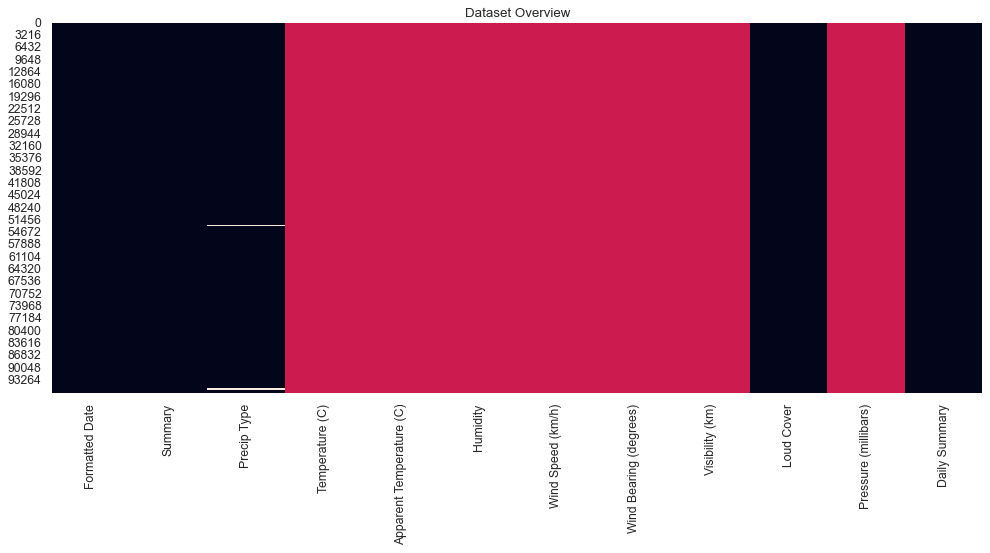

 Categerocial   Numeric   NaN 


In [30]:
dic_cols = {col:utils_recognize_type(df3, col, max_cat=15) for col in df.columns}
heatmap = df.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
figure(figsize=(15, 6), dpi=80)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

Categorical data is a type of divided data into groups. Each group is composed by data of similar characteristics. However, numerical data is a type of data that expresses information in the form of numbers
Example of categorical data: gender, sex, race etc.

#### e. Handling the Outliers
Outliers are some extremely deviated values in our data from other observations. The existence of those outliers could lead to variances in results and can impact our analysis outcomes and we may end up drawing the wrong conclusions.

Manyreasons are behind outliers appearance : 
- Data entry errors : human errors during data collections
- Measurement errors or instrument errors
- Sampling errors
- Data processing error : occurs during data mining
- Natural novelties in data : natural outliers, which are not caused by any error

##### e.1- Finding the Outliers

- Only numerical columns are considered in ouliers analysis 
- Outliers can be detected using:
    - Some statistical plots such as Box Plot, Scatter Plot and Histogram Plot (the most used ones).
    - Interquartile range 
    - Z-score
    
 #### e.2- Dealing with Outliers

Here are some methods about how we handle outliers : 
- Deleting the values: removing the value completely, if we are sure that this value is wrong and it will never occur again (using Interquartile range or Z-score)
- Replace the values: change the values if we know the reason for the outliers. (Example: 99th percentile)
- Data transformation: some times data transformation such as natural log reduces the variation caused by the extreme values. Most used for highly skewed data sets.

It is important to understand reasons and causes behind the existence of outliers as it can demonstrate valuable evidences to better understand the data and any process performance behind. However, deleting outliers is not an optimal solution as it can contains precious information.

##### I- Uni-variate Analysis (boxplot)
A box and whisker plot—also called a box plot—displays the five-number summary of a set of data. The five-number summary is the minimum, first quartile, median, third quartile, and maximum.
Here in the next pciture, there is Box Plot Explained : 

<div>
<img src="box-whisker-plot.jpg" width="500"/>
</div>




<Axes: xlabel='Humidity'>

<Figure size 640x480 with 0 Axes>

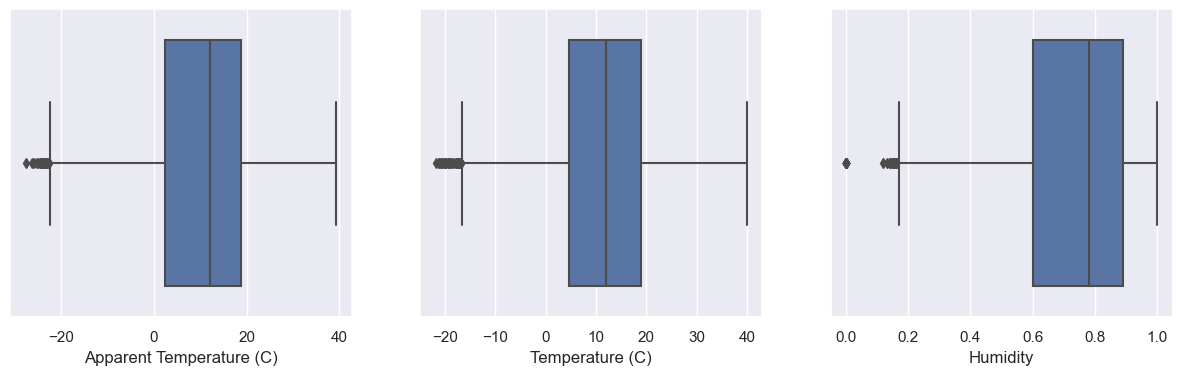

In [31]:
plt.figure()
figure(figsize=(15, 4))
plt.subplot(1,3,1)
sns.boxplot(x=df3['Apparent Temperature (C)'])
plt.subplot(1,3,2)
sns.boxplot(x=df3['Temperature (C)'])
plt.subplot(1,3,3)
sns.boxplot(x=df3['Humidity'])

<Axes: xlabel='Visibility (km)'>

<Figure size 640x480 with 0 Axes>

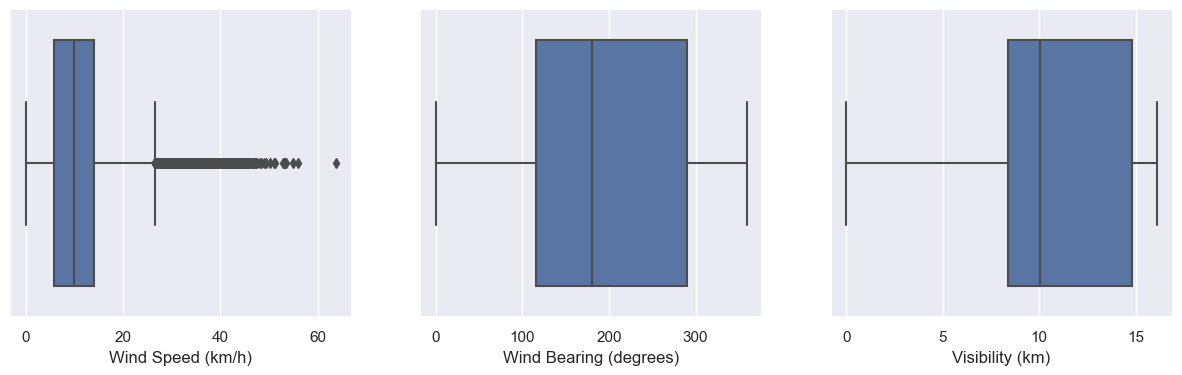

In [32]:
plt.figure()
figure(figsize=(15, 4))
plt.subplot(1,3,1)
sns.boxplot(x=df3['Wind Speed (km/h)'])
plt.subplot(1,3,2)
sns.boxplot(x=df3['Wind Bearing (degrees)'])
plt.subplot(1,3,3)
sns.boxplot(x=df3['Visibility (km)'])

From the Figures above, it is clear that two columns `Wind Bearing (degrees)` and `Visibility (km)` does not have any outliers while other columns have some ouliers that should be removed for better results

##### II- Bi-variate Analysis (scatter plot)
A scatter plot (aka scatter chart, scatter graph) uses dots to represent values for two different numeric variables. The position of each dot on the horizontal and vertical axis indicates values for an individual data point. Scatter plots are used to observe relationships between variables. 

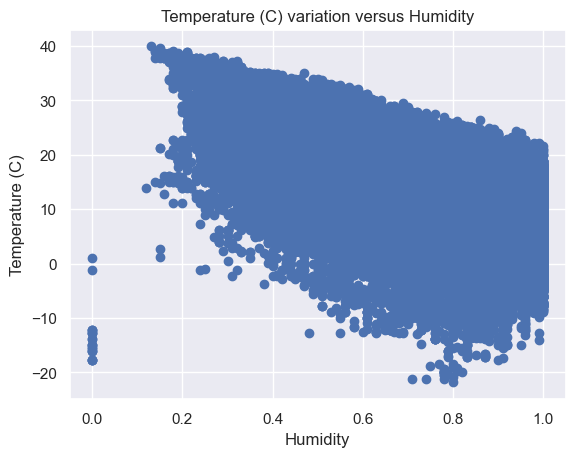

In [33]:
plt.figure()
plt.scatter(df3['Humidity'], df3['Temperature (C)'] )
plt.title('Temperature (C) variation versus Humidity')
plt.xlabel('Humidity')
plt.ylabel('Temperature (C)')
plt.show()

<Figure size 640x480 with 0 Axes>

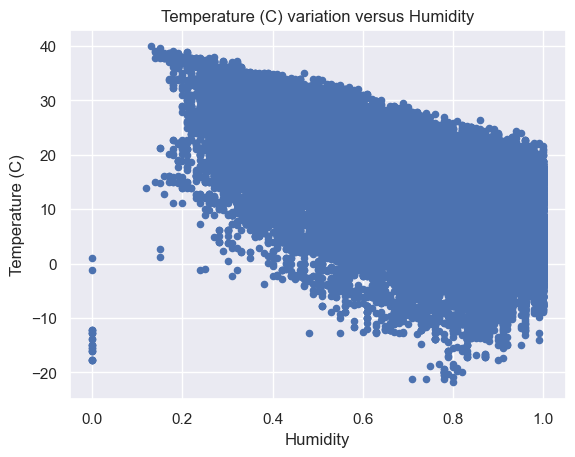

In [34]:
plt.figure()
df.plot.scatter(x = 'Humidity', y = 'Temperature (C)')
plt.title('Temperature (C) variation versus Humidity')
plt.xlabel('Humidity')
plt.ylabel('Temperature (C)')
plt.show()

It seems that the next two columns `Wind Speed (km/h)` and `Pressure (millibars)` columns have a higher number of outliers and they should be removed.

In [35]:
#Calulating outliers for all columns using the function outlier_percent defined at the beginning 
df_selct=['Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)']
for column in df_selct:
    data1 = df3[column]
    percent = str(round(outlier_percent(data1), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "Temperature (C)": 0.04%
Outliers in "Apparent Temperature (C)": 0.02%
Outliers in "Humidity": 0.05%
Outliers in "Wind Speed (km/h)": 3.11%
Outliers in "Wind Bearing (degrees)": 0.0%
Outliers in "Visibility (km)": 0.0%
Outliers in "Loud Cover": 0.0%
Outliers in "Pressure (millibars)": 4.61%


#### III- Solution 1: Interquartile range 

**IQR = Q3-Q1** 

The interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data. Actually, it
tells you the spread of the middle half of your distribution.

 **What is a quartile ?**

In statistics, a quartile is a type of quantile which divides the number of data points into four equal parts (called also quarters) means with equal size. Moreover, the data must be ordered from smallest to largest to compute quartiles. The three main quartiles are as follows:

    - Q1 : the first quartile, called also lower quartile as it corresponds to 25% of your data and 25% of your data is below this point, it is defined as the middle number between the smallest number (minimum) and the median of the data set.
    - Q2 : the second quartile which corresponds to the median of a data set. Thus 50% of the data lies below this point.
    - Q3 :  the third quartile which corresponds to the middle value between the median and the highest value (maximum) of the data set. It is also known as the upper quartile, as 75% of the data lies below this point.

In [36]:
#Calculating the outliers for Pressure (millibars) 
Q1 = df3['Pressure (millibars)'].quantile(0.25)
Q3 = df3['Pressure (millibars)'].quantile(0.75)
IQR = Q3 - Q1

In [37]:
print("The value of Q1 is:",Q1)
print("The value of Q3 is:",Q3)
print("The value of IQR is:",IQR)

The value of Q1 is: 1011.89
The value of Q3 is: 1021.05
The value of IQR is: 9.159999999999968


In [38]:
LOWER = Q1 - (1.5 * IQR)
UPPER = Q3 + (1.5 * IQR)
print("The value of upper bound is:",round(UPPER))
print("The value of lower bound is:",round(LOWER))

The value of upper bound is: 1035
The value of lower bound is: 998


In [39]:
num_outliers =  np.sum((df3['Pressure (millibars)'] < LOWER) |(df3['Pressure (millibars)'] > UPPER))
num_total = df3['Pressure (millibars)'].count()
(num_outliers/num_total)*100   

4.6103652434956635

We have 4.6% of our `Pressure (millibars)` values are belonging to outliers and should be removed. 

In [40]:
clean_data=df3[~((df3['Pressure (millibars)']<(LOWER))  |  (df3['Pressure (millibars)']>(UPPER)))]
clean_data

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [41]:
#Calculating the outliers for Wind Speed (km/h)
Q1 = df3['Wind Speed (km/h)'].quantile(0.25)
Q3 = df3['Wind Speed (km/h)'].quantile(0.75)
IQR = Q3 - Q1

In [42]:
print("The value of Q1 is:",Q1)
print("The value of Q3 is:",Q3)
print("The value of IQR is:",IQR)

The value of Q1 is: 5.796
The value of Q3 is: 14.1358
The value of IQR is: 8.3398


In [43]:
LOWER = Q1 - (1.5 * IQR)
UPPER = Q3 + (1.5 * IQR)
num_outliers =  np.sum((df3['Wind Speed (km/h)'] < LOWER) |(df3['Wind Speed (km/h)'] > UPPER))
num_total = df3['Wind Speed (km/h)'].count()
(num_outliers/num_total)*100  

3.1135340226817876

We have 3% of `Wind Speed (km/h)` values are belonging to outliers and should be removed

In [44]:
clean_data1=clean_data[~((clean_data['Wind Speed (km/h)']<(LOWER))  |  (clean_data['Wind Speed (km/h)']>(UPPER)))]
clean_data1

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


#### IV- Solution 2 : Z-Score

**Removing outliers for the `Pressure (millibars)`**

In [45]:
# Detecting outliers for Pressure (millibars)
mean = np.mean(df3["Pressure (millibars)"]) 
std = np.std(df3["Pressure (millibars)"]) 
print('mean of the Pressure (millibars) is :', mean) 
print('std. deviation of the Pressure (millibars) is :', std) 

mean of the Pressure (millibars) is : 1003.1500376292528
std. deviation of the Pressure (millibars) is : 117.27636503519463


In [46]:
threshold =3 # can be also 2 or 4
z_score = np.abs((df3["Pressure (millibars)"] - mean) / std)
good = z_score < threshold   ### Bad are those with False
num_outliers=np.sum(good==False)
print(f"z-score of {threshold} corresponds to a prob of {100 * 2 * norm.sf(3):0.2f}%")
print(f"Rejection {(~good).sum()} points")
print('Outliers in Pressure (millibars) is :',(num_outliers/num_total)*100)  

z-score of 3 corresponds to a prob of 0.27%
Rejection 1288 points
Outliers in Pressure (millibars) is : 1.3425617078052035


z-score of 2 corresponds to a prob of 0.27%
Rejection 1288 points
z-score of 3 corresponds to a prob of 0.27%
Rejection 1288 points
z-score of 4 corresponds to a prob of 0.27%
Rejection 1288 points
z-score of 5 corresponds to a prob of 0.27%
Rejection 1288 points


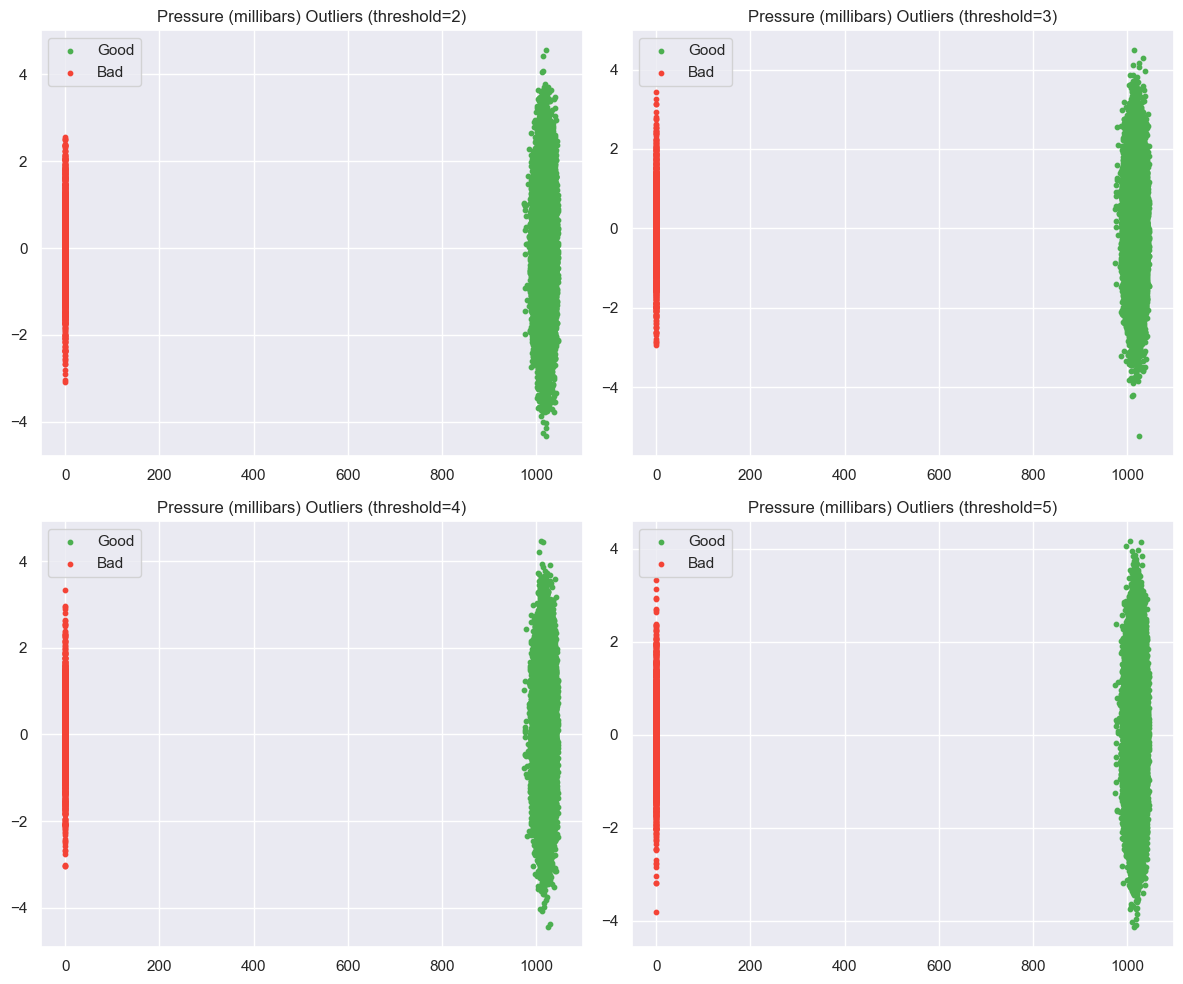

In [67]:
data=df3["Pressure (millibars)"]
plt.figure(figsize=(12, 10))
for i, threshold in zip(range(1, 5), range(2, 6)):
    plt.subplot(2, 2, i)
    visual_scatter = np.random.normal(size=data.shape[0])
    good = z_score(data, threshold=threshold)
    plt.scatter(data[good], visual_scatter[good], s=10, label="Good", color="#4CAF50")
    plt.scatter(data[~good], visual_scatter[~good], s=10, label="Bad", color="#F44336")
    plt.legend()
    plt.title(f"Pressure (millibars) Outliers (threshold={threshold})")
plt.tight_layout()

In [68]:
z = np.abs(stats.zscore(df_select))
#only keep rows in dataframe with all z-scores less than absolute value of 3 
data_clean2 = df_select[(z<3).all(axis=1)]

In [69]:
data_clean2.shape

(93915, 7)

In [70]:
# threshold = 3
# outlier = [] 
# for i in df3["Pressure (millibars)"]: 
#     z = np.abs((i-mean)/std)
#     #print(z)
#     if z > threshold:
#         outlier.append(i) 
# #print('outlier in dataset is', outlier) 

#### V- Replace the values 

In [71]:
#Doing it for the Wind Speed (km/h) column
ninety_ninth_percentile=df3['Wind Speed (km/h)'].quantile(0.99)
print('The 99th percentile for is :', ninety_ninth_percentile)

The 99th percentile for is : 32.8923


In [72]:
df3['Wind Speed (km/h)']=[33 if x>33 else x for x in df3['Wind Speed (km/h)']]

/var/folders/x_/_mmvg5sn65b5cx8542pkt62w0000gp/T/ipykernel_7680/1653513497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Wind Speed (km/h)']=[33 if x>33 else x for x in df3['Wind Speed (km/h)']]


#### b.Deleting the values 

## 4- Data transformation  
### 4.1- Log Transformation

The log transformation is the most popular among the different types of transformations used in machine learning. It aims to make highly skewed distributions less skewed. If the original data follows a log-normal distribution or approximately so, then the log-transformed data follows a normal or near normal distribution. Generally, we use the natural logarithm function in Log transformation.


However, our real raw data do not always follow a normal distribution. They are often so skewed making the results of our statistical analyses invalid. That’s where Log Transformation comes in.


The normal distribution is very useful in machine learning becasue it has deterministic statistical characteristics  and it helps detect linear relationship between variables. It consists that mode=mean=median: 

- Mean: called also average of a data set and it is found by summing all numbers in the data set and then dividing by the number of values in the set.
- Mode : it is the value that appears most often in a set of data values.
- Median : the middle number; found by ordering all data points and picking out the one in the middle (or if there are two middle numbers, taking the mean of those two numbers).


### 4.2- Data Normalization 
- Data normalization consists of transforming features to be on a similar scale all from 0 to 1. This improves the performance and training stability of the model. 
- Actually, not all datasets requires normalization, it is only required when the features range difference is very high. for example feature1 varies from 0 to 20 while feature2 varies from 1000 to 5000.

There are three common normalization techniques may be useful : 
- Min-Max Normalization, called also Scaling to a range. This can give us an idea about the range of values and is helpful to detect outliers. It subtracts the minimum value from each column’s highest value and divide by the range. Each new column has a minimum value of 0 and a maximum value of 1. 

- z-score : called also Standardization Scaling. It is also identified as Standardisation technique. It transforms your feature distributions to have 0 as mean and 1 as std (so, to have normal distribution). It’s useful when there are a few outliers, but not so extreme that you need clipping. It is a variation of scaling that represents the number of standard deviations away from the mean. Mean and standard deviation. 


- Feature Clipping : used also to remove outliers. It consists on capping all feature values greater or less then a threshold (can be 99th-percentile) to a fixed value. For example, all battery values below 15 are clipped to be exactly 15.
- log scaling : transform data to log values to compress a wide range to a narrow range. For example [0-35000] tranformed to [0-9]

Note : 
- Normalization could be called scalling also.
- The mean shows us the central tendency of the distribution.
- The standard deviation quantifies its amount of variation. 
- For example, a low standard deviation suggests that data points tend to be close to the mean. 

### 4.3- Data Standardisation 
- Normalization and standardization are not the same things. 
- Standardization, interestingly, refers to setting the mean to zero and the standard deviation to one.
- Normalization in machine learning is the process of translating data into the range [0, 1] (or any other range) or simply transforming data onto the unit sphere.
- z-score : called also **Standardization Scaling**. 

###  4.4- Transforming categorical values to numeric variables

First of all, categorical variables can be divided into two categories:
* Nominal: no particular order
* Ordinal: there is some order between values

###### Why do we need to transform Categorical data to numerical ones ?

- Transforming categorical data to numerical data is an important step in many data analysis tasks.
- Categorical features Corresponds to string data types that is easily understood by human beings and hard to understand by machines.
- Categorical data must be converted into numerical data for further processing.
- Some machine learning algorithms do not accept categorical variables

In fact, there is three method to deal with categorical data: 

* Drop categorical variables : we could lose a lot of important information. It is not very recommended
* Ordinal encoding : it is not very recommended because it assumes certain order /ranking in the column values
* One-hot encoding : the best choice (most common and correct way). It consists on adding one column for each possible value. However, be careful if our dataset is very large so this method can greatly expand the size of the dataset (may keep only low cardinality columns and delete the ones with high cardinality)

#### Solution 1: Using Python’s Category Encoder Library
category_encoders is an amazing Python library that provides 15 different encoding schemes.
- One-hot Encoding
- Label Encoding
- Ordinal Encoding
- Helmert Encoding
- Binary Encoding
- Frequency Encoding
- Mean Encoding
- Weight of Evidence Encoding
- Probability Ratio Encoding
- Hashing Encoding
- Backward Difference Encoding
- Leave One Out Encoding
- James-Stein Encoding
- M-estimator Encoding
- Thermometer Encoder

In [ ]:
# One hot encoding 
ce_OHE = ce.OneHotEncoder(cols=['Summary','Precip Type'])

data1 = ce_OHE.fit_transform(df)
data1.head()

In [ ]:
# Binary Encoding
binary_enc = ce.BinaryEncoder(cols=['Summary']);

# transform the data
data_binary = binary_enc.fit_transform(df['Summary']);
data_binary

#### Solution 2: Dummy Variable Encoding 
###### Using Pandas' Get Dummies


In [ ]:
pd.get_dummies(df,columns=['Summary','Precip Type'])

#### Solution 3: Using Scikit-learn
Scikit-learn also has 15 different types of built-in encoders, which can be accessed from sklearn.preprocessing.

In [ ]:
# Scikit-learn One-hot Encoding
one_he = OneHotEncoder(handle_unknown='ignore',sparse=False)
data_summary = pd.DataFrame(one_he.fit_transform(df[["Summary"]]))

data_summary

In [ ]:
# Scikit-learn Label Encoding
label_enc = LabelEncoder()
# Label encoder takes no arguments
label_enc_summary = label_enc.fit_transform(df[['Summary']])

In label encoding, each category is assigned a value from 1 through N where N is the number of categories for the feature. There is no relation or order between these assignments.

In [ ]:
label_enc_summary

#### Note!!  Pandas Label Encoding
It is also possible to use  `cat.codes` method of pandas for label encoding

#### Solution 4 : Ordinal Encoding
Ordinal encoding is used to retain the ordinal (ordered) nature of the variable while encoding it. It is very similar to label encoding, the only difference is that Label encoding discard variables order. 
So, Ordinal Encoding assigns a sequence of integers.

In [ ]:
# here is an external example as in our dataset we do not have a good example for Ordinal encoding
weather = {'Weather' :['very cold', 'cold', 'warm', 'hot', 'very hot']}
df_aus=pd.DataFrame(weather,columns=["Weather"])
weather_dict = {'very cold': 1,'cold': 2,'warm': 3,'hot': 4,"very hot":5}
df_aus

### How to choose the best Encoding Method 
Actually, it is not possible to say that there is one encoding technique that best fits almost all the problems. Choosing the Encoding Method depends on a lot of factors such as if we need to keep order or not?, the size of our dataset, etc. 
Generally, get_dummies method has an advantage as it could be easily implmented.